In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import tensorflow as tf

from keras.models import Model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout ,GlobalAveragePooling2D,InputLayer,MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from keras.applications.vgg16 import VGG16 as vg

tf.random.set_seed(34)

In [2]:
base_path = '/Users/umayyentur/Documents/YapayZekaMühendisliğiYüksekLisansı/dogs-vs-cats'


def create_dataframe(img_dir):
    file_paths = []
    labels = []
    for filename in os.listdir(img_dir):
        if filename.endswith('.jpg'):
            file_paths.append(os.path.join(img_dir, filename))
            label = 'cat' if filename.startswith('cat') else 'dog'
            labels.append(label)  
    return pd.DataFrame({'filename': file_paths, 'label': labels})


train_df = create_dataframe(os.path.join(base_path, 'train'))
valid_df = create_dataframe(os.path.join(base_path, 'valid'))
test_df = create_dataframe(os.path.join(base_path, 'test'))

In [3]:
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(224,224),
batch_size=BATCH_SIZE,
class_mode='binary'
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


### Model 

In [4]:
base_model = vg(weights="imagenet", include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation="sigmoid")(x) 

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

2024-10-30 10:39:02.342414: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-30 10:39:02.342448: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-30 10:39:02.342454: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-30 10:39:02.342472: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 10:39:02.342488: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
EPOCHS = 20

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)


history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 801s 1s/step - accuracy: 0.9192 - loss: 0.2105 - val_accuracy: 0.9076 - val_loss: 0.2181
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 796s 1s/step - accuracy: 0.9179 - loss: 0.2049 - val_accuracy: 0.9076 - val_loss: 0.2158
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 401s 639ms/step - accuracy: 0.9192 - loss: 0.2077 - val_accuracy: 0.9124 - val_loss: 0.2108
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 413s 661ms/step - accuracy: 0.9260 - loss: 0.1933 - val_accuracy: 0.9072 - val_loss: 0.2124
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 494s 790ms/step - accuracy: 0.9285 - loss: 0.1932 - val_accuracy: 0.9096 - val_loss: 0.2094
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 536s 856ms/step - accuracy: 0.9255 - loss: 0.1955 - val_accuracy: 0.9124 - val_loss: 0.2048
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 805s 1s/step - accuracy: 0.9224 - loss: 0.1971 - val_accuracy: 0.9136 - val_loss: 0.2028
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 621s 993ms/step - accuracy: 0.9248 - loss: 0.

### Model Graph

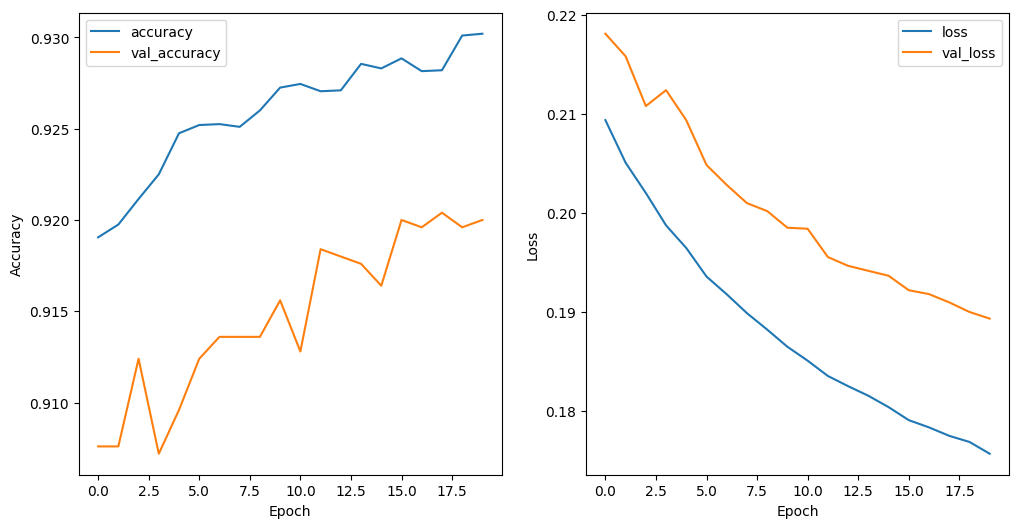

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Models Confuison Matrix

In [14]:
class_indices = train_generator.class_indices
print(class_indices)

{'cat': 0, 'dog': 1}


In [15]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 520ms/step - accuracy: 0.9391 - loss: 0.1741
Test Loss: 0.1843145489692688, Test Accuracy: 0.932692289352417
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 523ms/step


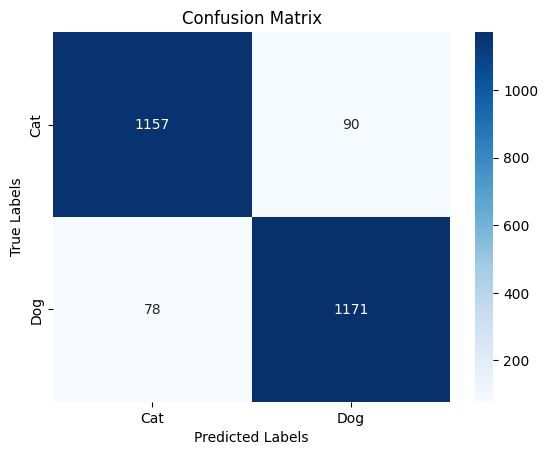

In [16]:
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten() 
true_classes = test_generator.classes
true_classes = true_classes[:len(predicted_classes)]

conf_matrix = confusion_matrix(true_classes, predicted_classes)
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['Cat', 'Dog'])
ax.yaxis.set_ticklabels(['Cat', 'Dog'])

plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 521ms/step


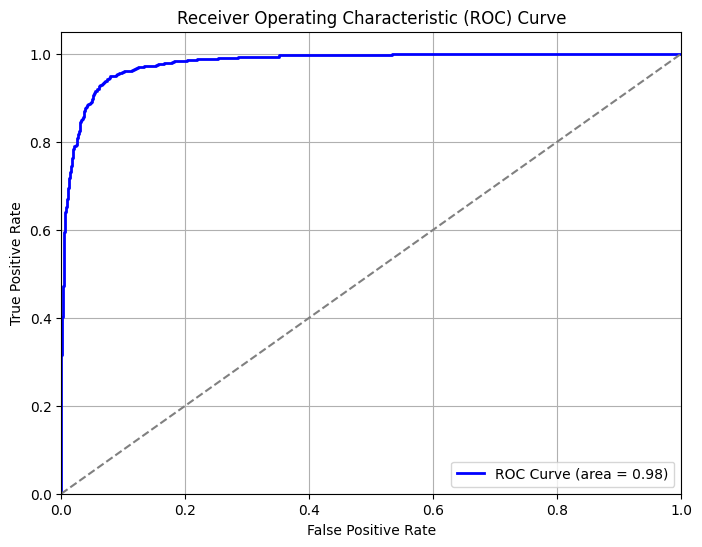

In [17]:
y_pred_prob = model.predict(test_generator, steps=len(test_df) // BATCH_SIZE + 1)
y_pred = np.round(y_pred_prob).astype(int) 


y_test = test_generator.classes


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()